In [1]:
import matplotlib.pyplot as plt
import xtrack as xt
import scipy as sc
import bpmeth
import sympy as sp
import math
import numpy as np
from cpymad.madx import Madx
from sympy.abc import alpha, beta  # Cool notebook greek letters!
import sys
import warnings
import nafflib
from HeLICS_FFA import calc_FMA


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2026.02.06 16:05:12      +
  ++++++++++++++++++++++++++++++++++++++++++++
! ==== DRIFTS =====

q_drift        = 1.05;

mb_drift       = 0.2;

mb_quad_drift  = 0.15; // space mb2q + endcoils Q

sx_drift       = 0.5;

ss_drift       =  4.;



! ==== DIPOLE GEOMETRY ====

edge          = 30./180.*pi;

ein1          := edge;  

eout1         := edge;

fint	      = 0.42;

hgap          = 0.035;



phi            = 60./180.*pi;

rho            = 2.737;

mb_len        := phi*rho;



! ==== QUADRUPOLE STRENGTHS =====

quad_len       = 0.2;

qb_len         = 0.400;

qf_len         = 0.400;

qd_len         = 0.235;

sx_len         = 0.115;



mb_k1          = -0.11; 

qb_k1          = 2.8067743015574944;

qf_k1          = 2.6880579191671385;  

qd_k1          = -2.9440570148491068;



! ===

Converting sequence "he_ring": 100%|██████████| 73/73 [00:00<00:00, 1063.52it/s]


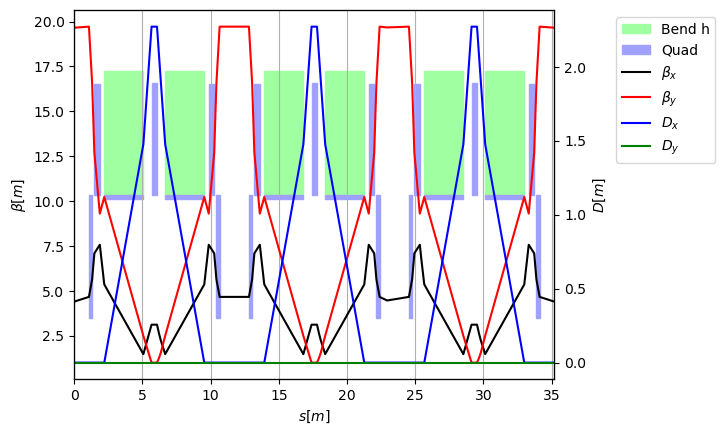

In [2]:
##################
# HeLICS lattice #
##################

mad=Madx()
mad.call("/home/silke/Documents/HeLICS/HeLICS.str")
mad.call("/home/silke/Documents/HeLICS/HeLICS.seq")
mad.beam()
mad.use("he_ring")

def match_tunes(madx,qx,qy):
    madx.input(f'''
    use, sequence=he_ring;
    MATCH;
    GLOBAL, Q2={qy},Q1={qx};
    vary, name=qd_k1, step=0.0000001;
    vary, name=qf_k1, step=0.0000001;
    simplex, calls=5000, tolerance=1E-10;
    endmatch;''')
    qf = madx.eval('qf_k1')
    qd = madx.eval('qd_k1')
    return qf,qd

def match_disp(madx):
    madx.input(f'''
    use, sequence=he_ring;
    MATCH;
    constraint, sequence=he_ring, range = "qf2b", DX=0.0;
    vary, name=qb_k1, step=0.0000001;
    jacobian, calls=5000, tolerance=1E-10;
    endmatch;''')
    qb = madx.eval('qb_k1') 
    return qb

print("Matched to Qx 2.4, Qy 1.2 with quadrupole strengths qf, qd = ", match_tunes(mad, 2.39, 1.21))

fringe="linear"

line=xt.Line.from_madx_sequence(mad.sequence.he_ring)
line.configure_bend_model(edge=fringe, core='adaptive', num_multipole_kicks=30)
line.particle_ref=xt.Particles(mass0=0.931494 * 4.001506179127e9, q0=2., energy0=(0.931494 * 4.001506179127 + 0.02)*1e9)  # Energy in eV, top energy
start_elem = "lssc"
line.cycle(name_first_element=start_elem, inplace=True)  # Such that dipole is not spanning over end-beginning of lattice
    
tw0 = line.twiss4d()
tw0.plot()


In [3]:
calc_FMA(line, fringe="linear", n_turn=10000, nturn_tune=200)
calc_FMA(line, fringe="full", n_turn=10000, nturn_tune=200)

3200 particles created
Compiling expArray with signature (complex128, int64)
Compiling impl with signature (int64, omitted(default=<class 'float'>))
Compiling impl with signature (int64, Function(<class 'float'>))
Compiling impl with signature (typeref[<class 'numba.core.types.npytypes.Array'>], int64, uint32)
Compiling impl with signature (Array(float64, 1, 'C', False, aligned=True),)
3200 particles created


/home/silke/Documents/repositories/examples/HeLICS/ring/HeLICS_FFA.py:87: RuntimeWarning: divide by zero encountered in log10
  dQ = np.log10(np.sqrt((tunediff(Qx1, Qx2))**2 + tunediff(Qy1, Qy2)**2))


In [4]:
def plot_spectrum(hxm, ax):
    hfmin = np.fft.fft(hxm)
    hfminabs = np.abs(hfmin)
    hfminabs = np.fft.fftshift(hfminabs)        
    ff = np.fft.fftfreq(len(hxm))
    ff = np.fft.fftshift(ff)
    ax.plot(ff, np.log(hfminabs))

NameError: name 'hxm1' is not defined

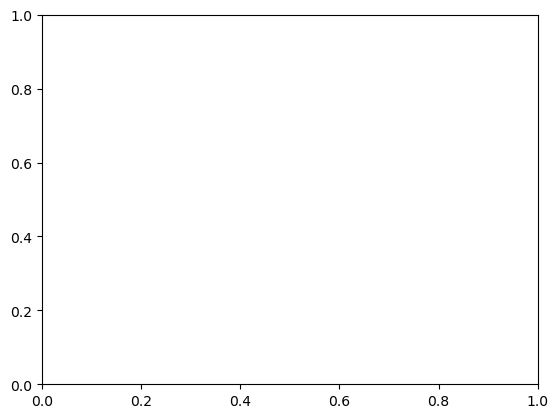

In [5]:
fig, ax = plt.subplots()
plot_spectrum(hxm1[5], ax)
plot_spectrum(hxm2[5], ax)